In [60]:
import os

import matplotlib.pyplot as plt
import numpy as nmp
import pandas as pds
import scipy.interpolate as sci

%matplotlib notebook

Generate array of datasets for import

In [69]:
data_dirs = [
    "Babu2013",
    "Follansbee1989",
    "Lee1998",
    "Nemat-Nasser2001",
    "Seo2005",
    "Zhou2017",
    "Casem2018",
]
location = "../Data/SHPB"
csvfile_name = {}
for data_dir in data_dirs:
    data_dir_full = os.path.join(location, data_dir)
    csvfile_name[data_dir] = []
    for csvfile in os.listdir(data_dir_full):
        if csvfile.endswith(".csv") and not csvfile.endswith(".Plast.csv"):
            csvfile_name[data_dir].append(os.path.join(data_dir_full, csvfile))
# print csvfile_name['Zhou2017']

Import data arrays in nested dicts (first by author, then by experiment) using pandas.

In [70]:
name_dict = {}
for name in data_dirs:
    name_dict[name] = {}
    for csvfile in csvfile_name[name]:
        csvname = csvfile.split("/")[-1].split(".")[0]
        name_dict[name][csvname] = pds.read_table(csvfile, sep=",", header=17)

# list(name_dict['Follansbee1989']['Follansbee1989_Fig12-189K-15e-4'].columns)

Plot data arrays individually. (Copy cells if new data added to filelist above)

<IPython.core.display.Javascript object>


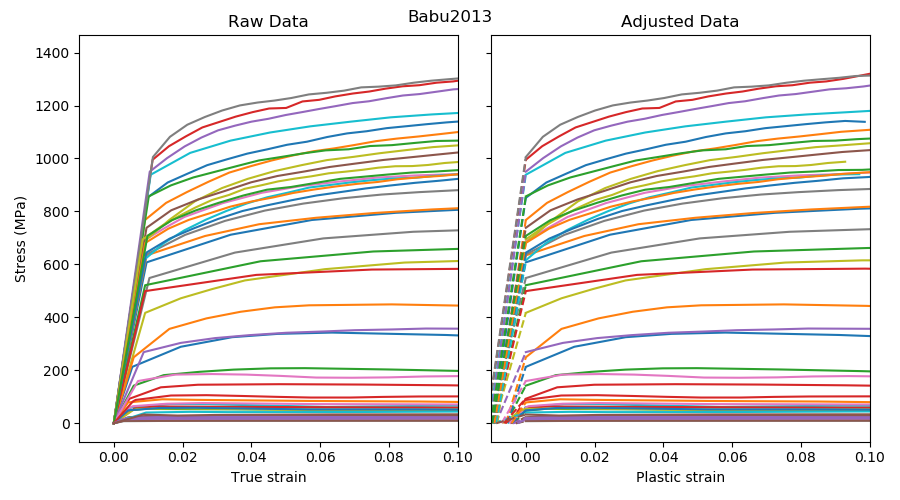

In [456]:
k = "Babu2013"
threshold = 16e3
threshold2 = 9e3
threshold3 = 1e3
xax_lim = (-0.01, 0.1)
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(9, 5))
for ii, kk in enumerate(name_dict[k]):
    #     fig3Flag = 'Fig3' in kk
    x = name_dict[k][kk]["True strain"]
    y = name_dict[k][kk][" stress (MPa)"]
    # Compute first order spline
    y_spl = sci.UnivariateSpline(x, y, s=0, k=1)

    # Compute 1st and 2nd derivative of spline, near linear sections going to have near zero 2nd derivative
    x_range = nmp.linspace(x.values[0], x.values[-1], 1000)
    grad1 = nmp.gradient(y_spl(x_range), x_range)
    grad2 = nmp.gradient(grad1, x_range)

    # Find where slope ofd the spline decreases below threshold value to find non-linearity
    if max(grad1) > threshold:
        for index, value in enumerate(grad1):
            if abs(value) < threshold:
                x_yield_temp = x_range[index]
                x_index = (nmp.abs(x_yield_temp - x)).idxmin()
                x_yield = x.values[x_index]
                break
    elif max(grad1) > threshold2 and max(grad1) <= threshold:
        for index, value in enumerate(grad1):
            if abs(value) < threshold2:
                x_yield_temp = x_range[index]
                x_index = (nmp.abs(x_yield_temp - x)).idxmin()
                x_yield = x.values[x_index]
                break
    else:
        for index, value in enumerate(grad1):
            if abs(value) < threshold3:
                x_yield_temp = x_range[index]
                x_index = (nmp.abs(x_yield_temp - x)).idxmin()
                x_yield = x.values[x_index]
                break

    # Split original strain vector into old and new
    x_elastic = x.values[: x_index + 1] - x_yield
    y_elastic = y.values[: x_index + 1]

    x_plastic = x.values[x_index:] - x_yield
    y_plastic = y.values[x_index:]

    # Read old .csv file and write new plastic strain/stress data
    true_filename = os.path.join(location, k, kk) + ".csv"
    true_lines = []
    with open(true_filename, "r") as fr:
        for linenum, line in enumerate(fr):
            if linenum < 17:
                true_lines.append(line)

    # Write new .csv file with plastic strain
    plastic_filename = os.path.join(location, k, kk) + ".Plast.csv"
    plastic_lines = ["Plastic strain, stress (MPa)\n"]
    for strain_index, plast_strain in enumerate(x_plastic):
        strain_string = "{eps:.6}, {omega:.6}\n".format(
            eps=plast_strain, omega=y_plastic[strain_index]
        )
        plastic_lines.append(strain_string)

    write_lines = true_lines + plastic_lines
    with open(plastic_filename, "w") as fw:
        for write_line in write_lines:
            fw.write(write_line)

    # Plot original and offset results
    ax1.plot(x, y)

    # Plot shifted elastic...
    ax2.plot(x_elastic, y_elastic, "--")
    # ... and plastic data
    ax2.plot(x_plastic, y_plastic, "-", color=plt.gca().lines[-1].get_color())
fig.suptitle(k, fontsize=12)
ax1.set(
    title="Raw Data",
    xlabel="True strain",
    ylabel="Stress (MPa)",
    xlim=xax_lim,
    #         ylim=(-100,1500),
)
ax2.set(
    title="Adjusted Data",
    xlabel="Plastic strain",
    xlim=xax_lim,
)
plt.tight_layout()

<IPython.core.display.Javascript object>


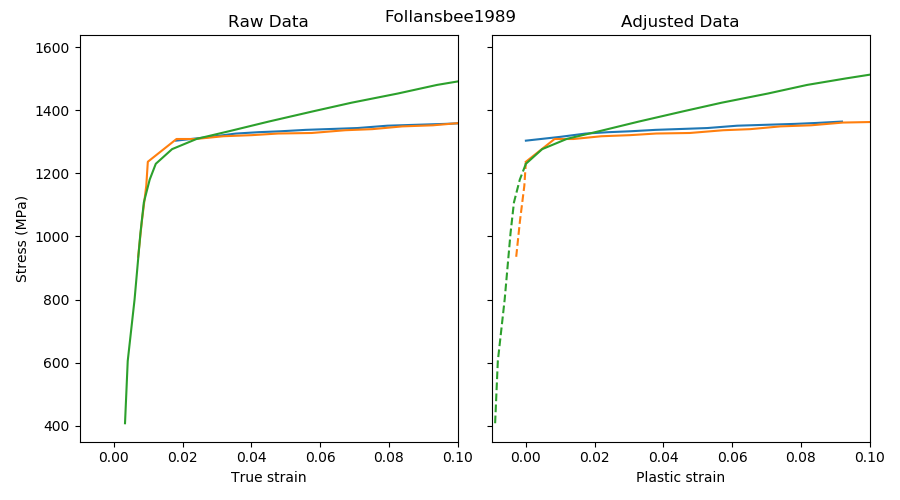

In [457]:
k = "Follansbee1989"
threshold = 16e3
xax_lim = (-0.01, 0.1)
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(9, 5))
for ii, kk in enumerate(name_dict[k]):
    x = name_dict[k][kk]["True strain"]
    y = name_dict[k][kk][" stress (MPa)"]
    # Compute first order spline
    y_spl = sci.UnivariateSpline(x, y, s=0, k=1)

    # Compute 1st and 2nd derivative of spline, near linear sections going to have near zero 2nd derivative
    x_range = nmp.linspace(x.values[0], x.values[-1], 1000)
    grad1 = nmp.gradient(y_spl(x_range), x_range)
    grad2 = nmp.gradient(grad1, x_range)

    # Find where slope ofd the spline decreases below threshold value to find non-linearity
    for index, value in enumerate(grad1):
        if abs(value) < threshold:
            x_yield_temp = x_range[index]
            x_index = (nmp.abs(x_yield_temp - x)).idxmin()
            x_yield = x.values[x_index]
            break

    # Split original strain vector into old and new
    x_elastic = x.values[: x_index + 1] - x_yield
    y_elastic = y.values[: x_index + 1]

    x_plastic = x.values[x_index:] - x_yield
    y_plastic = y.values[x_index:]

    # Read old .csv file and write new plastic strain/stress data
    true_filename = os.path.join(location, k, kk) + ".csv"
    true_lines = []
    with open(true_filename, "r") as fr:
        for linenum, line in enumerate(fr):
            if linenum < 17:
                true_lines.append(line)

    # Write new .csv file with plastic strain
    plastic_filename = os.path.join(location, k, kk) + ".Plast.csv"
    plastic_lines = ["Plastic strain, stress (MPa)\n"]
    for strain_index, plast_strain in enumerate(x_plastic):
        strain_string = "{eps:.6}, {omega:.6}\n".format(
            eps=plast_strain, omega=y_plastic[strain_index]
        )
        plastic_lines.append(strain_string)

    write_lines = true_lines + plastic_lines
    with open(plastic_filename, "w") as fw:
        for write_line in write_lines:
            fw.write(write_line)

    # Plot original and offset results
    ax1.plot(x, y)

    # Plot shifted elastic...
    ax2.plot(x_elastic, y_elastic, "--")
    # ... and plastic data
    ax2.plot(x_plastic, y_plastic, "-", color=plt.gca().lines[-1].get_color())
fig.suptitle(k, fontsize=12)
ax1.set(
    title="Raw Data",
    xlabel="True strain",
    ylabel="Stress (MPa)",
    xlim=xax_lim,
    #         ylim=(-100,1500),
)
ax2.set(
    title="Adjusted Data",
    xlabel="Plastic strain",
    xlim=xax_lim,
)
plt.tight_layout()

The Lee 1998 data is shown as true strain but when plotted looks much like it is already been adjusted to plastic strain. The headers in the file have been adjusted subsequently.

<IPython.core.display.Javascript object>


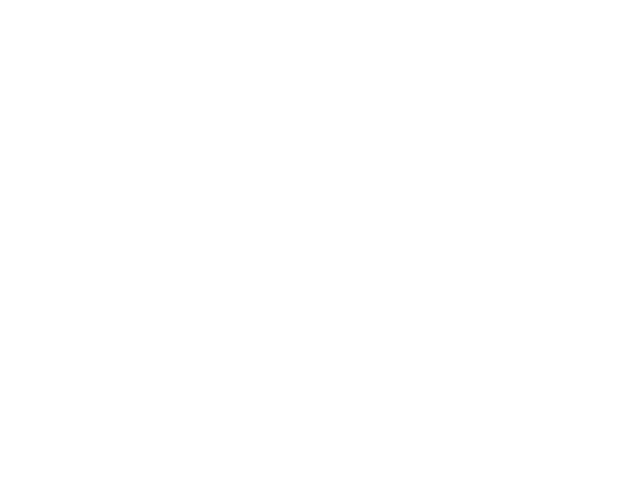

In [458]:
k = "Lee1998"
plt.figure()
for kk in name_dict[k]:
    plt.plot(
        name_dict[k][kk]["Plastic strain"], name_dict[k][kk][" stress (MPa)"]
    )
    plt.title(k)

<IPython.core.display.Javascript object>


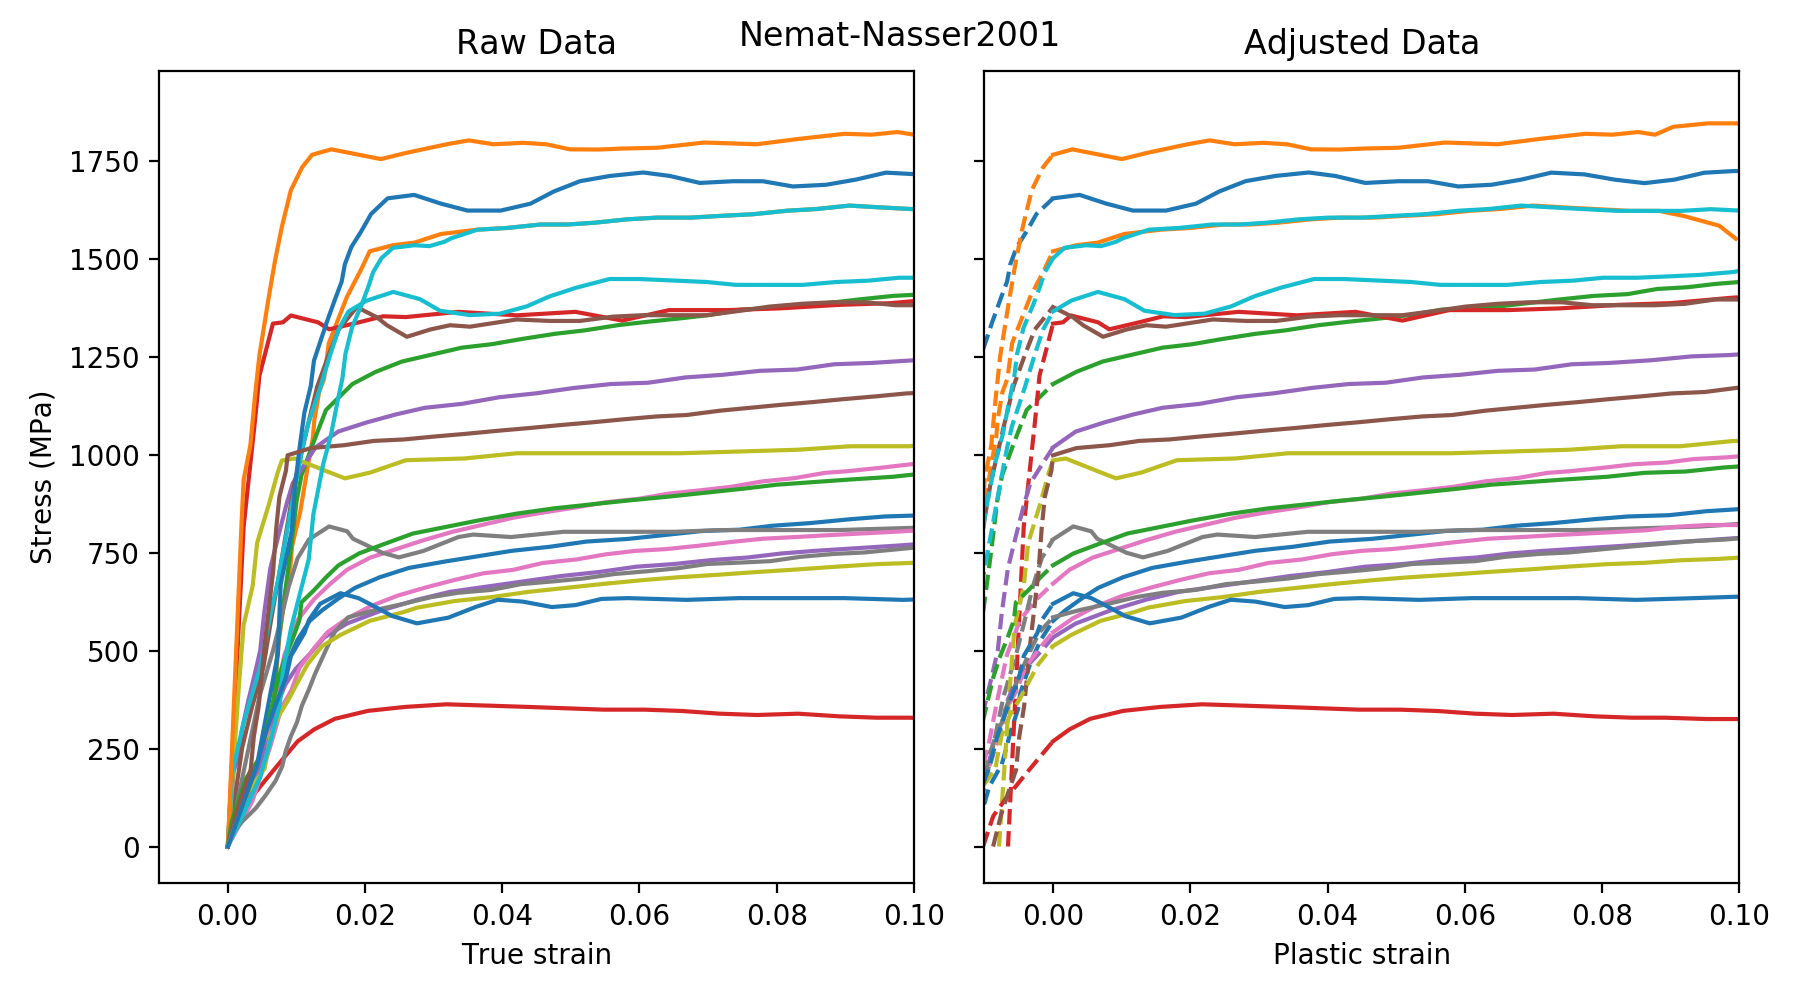

In [22]:
k = "Nemat-Nasser2001"
threshold = 16e3
xax_lim = (-0.01, 0.1)
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(9, 5))
for ii, kk in enumerate(name_dict[k]):
    x = name_dict[k][kk]["True strain"]
    y = name_dict[k][kk][" stress (MPa)"]
    # Compute first order spline
    y_spl = sci.UnivariateSpline(x, y, s=0, k=1)

    # Compute 1st and 2nd derivative of spline, near linear sections going to have near zero 2nd derivative
    x_range = nmp.linspace(x.values[0], x.values[-1], 1000)
    grad1 = nmp.gradient(y_spl(x_range), x_range)
    grad2 = nmp.gradient(grad1, x_range)

    # Find where slope ofd the spline decreases below threshold value to find non-linearity
    for index, value in enumerate(grad1):
        if abs(value) < threshold:
            x_yield_temp = x_range[index]
            x_index = (nmp.abs(x_yield_temp - x)).idxmin()
            x_yield = x.values[x_index]
            break

    # Split original strain vector into old and new
    x_elastic = x.values[: x_index + 1] - x_yield
    y_elastic = y.values[: x_index + 1]

    x_plastic = x.values[x_index:] - x_yield
    y_plastic = y.values[x_index:]

    # Read old .csv file and write new plastic strain/stress data
    true_filename = os.path.join(location, k, kk) + ".csv"
    true_lines = []
    with open(true_filename, "r") as fr:
        for linenum, line in enumerate(fr):
            if linenum < 17:
                true_lines.append(line)

    # Write new .csv file with plastic strain
    plastic_filename = os.path.join(location, k, kk) + ".Plast.csv"
    plastic_lines = ["Plastic strain, stress (MPa)\n"]
    for strain_index, plast_strain in enumerate(x_plastic):
        strain_string = "{eps:.6}, {omega:.6}\n".format(
            eps=plast_strain, omega=y_plastic[strain_index]
        )
        plastic_lines.append(strain_string)

    write_lines = true_lines + plastic_lines
    with open(plastic_filename, "w") as fw:
        for write_line in write_lines:
            fw.write(write_line)

    # Plot original and offset results
    ax1.plot(x, y)

    # Plot shifted elastic...
    ax2.plot(x_elastic, y_elastic, "--")
    # ... and plastic data
    ax2.plot(x_plastic, y_plastic, "-", color=plt.gca().lines[-1].get_color())
fig.suptitle(k, fontsize=12)
ax1.set(
    title="Raw Data",
    xlabel="True strain",
    ylabel="Stress (MPa)",
    xlim=xax_lim,
    #         ylim=(-100,1500),
)
ax2.set(
    title="Adjusted Data",
    xlabel="Plastic strain",
    xlim=xax_lim,
)
plt.tight_layout()

<IPython.core.display.Javascript object>


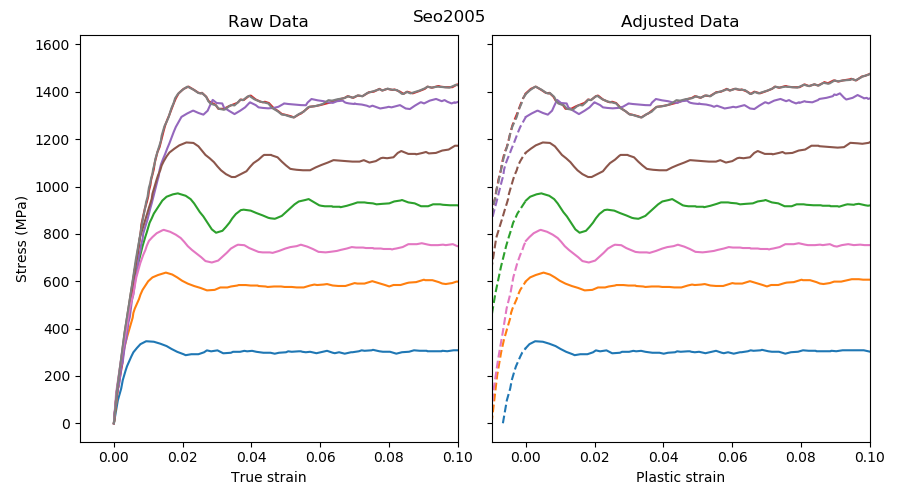

In [459]:
k = "Seo2005"
threshold = 16e3
xax_lim = (-0.01, 0.1)
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(9, 5))
for ii, kk in enumerate(name_dict[k]):
    x = name_dict[k][kk]["True strain"]
    y = name_dict[k][kk][" stress (MPa)"]
    # Compute first order spline
    y_spl = sci.UnivariateSpline(x, y, s=0, k=1)

    # Compute 1st and 2nd derivative of spline, near linear sections going to have near zero 2nd derivative
    x_range = nmp.linspace(x.values[0], x.values[-1], 1000)
    grad1 = nmp.gradient(y_spl(x_range), x_range)
    grad2 = nmp.gradient(grad1, x_range)

    # Find where slope ofd the spline decreases below threshold value to find non-linearity
    for index, value in enumerate(grad1):
        if abs(value) < threshold:
            x_yield_temp = x_range[index]
            x_index = (nmp.abs(x_yield_temp - x)).idxmin()
            x_yield = x.values[x_index]
            break

    # Split original strain vector into old and new
    x_elastic = x.values[: x_index + 1] - x_yield
    y_elastic = y.values[: x_index + 1]

    x_plastic = x.values[x_index:] - x_yield
    y_plastic = y.values[x_index:]

    # Read old .csv file and write new plastic strain/stress data
    true_filename = os.path.join(location, k, kk) + ".csv"
    true_lines = []
    with open(true_filename, "r") as fr:
        for linenum, line in enumerate(fr):
            if linenum < 17:
                true_lines.append(line)

    # Write new .csv file with plastic strain
    plastic_filename = os.path.join(location, k, kk) + ".Plast.csv"
    plastic_lines = ["Plastic strain, stress (MPa)\n"]
    for strain_index, plast_strain in enumerate(x_plastic):
        strain_string = "{eps:.6}, {omega:.6}\n".format(
            eps=plast_strain, omega=y_plastic[strain_index]
        )
        plastic_lines.append(strain_string)

    write_lines = true_lines + plastic_lines
    with open(plastic_filename, "w") as fw:
        for write_line in write_lines:
            fw.write(write_line)

    # Plot original and offset results
    ax1.plot(x, y)

    # Plot shifted elastic...
    ax2.plot(x_elastic, y_elastic, "--")
    # ... and plastic data
    ax2.plot(x_plastic, y_plastic, "-", color=plt.gca().lines[-1].get_color())
fig.suptitle(k, fontsize=12)
ax1.set(
    title="Raw Data",
    xlabel="True strain",
    ylabel="Stress (MPa)",
    xlim=xax_lim,
    #         ylim=(-100,1500),
)
ax2.set(
    title="Adjusted Data",
    xlabel="Plastic strain",
    xlim=xax_lim,
)
plt.tight_layout()

<IPython.core.display.Javascript object>


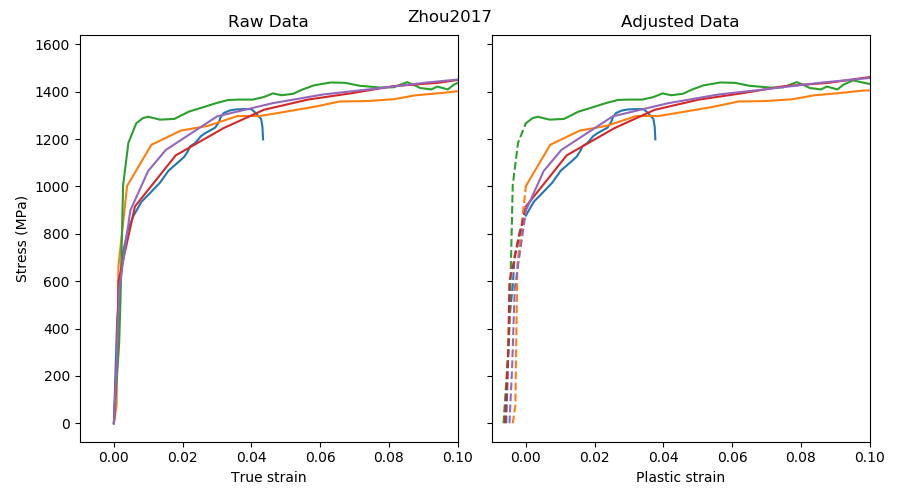

In [463]:
k = "Zhou2017"
threshold = 35e3
xax_lim = (-0.01, 0.1)
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(9, 5))
for ii, kk in enumerate(name_dict[k]):
    x = name_dict[k][kk]["True strain"]
    y = name_dict[k][kk][" stress (MPa)"]
    # Compute first order spline
    y_spl = sci.UnivariateSpline(x, y, s=0, k=1)

    # Compute 2nd derivative of spline, near linear sections going to have near zero 2nd derivative
    x_range = nmp.linspace(x.values[0], x.values[-1], 1000)
    grad1 = nmp.gradient(y_spl(x_range), x_range)
    grad2 = nmp.gradient(grad1, x_range)

    # Compute 1st and 2nd derivative of spline, near linear sections going to have near zero 2nd derivative
    x_range = nmp.linspace(x.values[0], x.values[-1], 1000)
    grad1 = nmp.gradient(y_spl(x_range), x_range)
    grad2 = nmp.gradient(grad1, x_range)

    # Find where slope ofd the spline decreases below threshold value to find non-linearity
    for index, value in enumerate(grad1):
        if abs(value) < threshold:
            x_yield_temp = x_range[index]
            x_index = (nmp.abs(x_yield_temp - x)).idxmin()
            x_yield = x.values[x_index]
            break

    # Split original strain vector into old and new
    x_elastic = x.values[: x_index + 1] - x_yield
    y_elastic = y.values[: x_index + 1]

    x_plastic = x.values[x_index:] - x_yield
    y_plastic = y.values[x_index:]

    # Read old .csv file and write new plastic strain/stress data
    true_filename = os.path.join(location, k, kk) + ".csv"
    true_lines = []
    with open(true_filename, "r") as fr:
        for linenum, line in enumerate(fr):
            if linenum < 17:
                true_lines.append(line)

    # Write new .csv file with plastic strain
    plastic_filename = os.path.join(location, k, kk) + ".Plast.csv"
    plastic_lines = ["Plastic strain, stress (MPa)\n"]
    for strain_index, plast_strain in enumerate(x_plastic):
        strain_string = "{eps:.6}, {omega:.6}\n".format(
            eps=plast_strain, omega=y_plastic[strain_index]
        )
        plastic_lines.append(strain_string)

    write_lines = true_lines + plastic_lines
    with open(plastic_filename, "w") as fw:
        for write_line in write_lines:
            fw.write(write_line)

    # Plot original and offset results
    ax1.plot(x, y)

    # Plot shifted elastic...
    ax2.plot(x_elastic, y_elastic, "--")
    # ... and plastic data
    ax2.plot(x_plastic, y_plastic, "-", color=plt.gca().lines[-1].get_color())
fig.suptitle(k, fontsize=12)
ax1.set(
    title="Raw Data",
    xlabel="True strain",
    ylabel="Stress (MPa)",
    xlim=xax_lim,
    #         ylim=(-100,1500),
)
ax2.set(
    title="Adjusted Data",
    xlabel="Plastic strain",
    xlim=xax_lim,
)
plt.tight_layout()

<IPython.core.display.Javascript object>


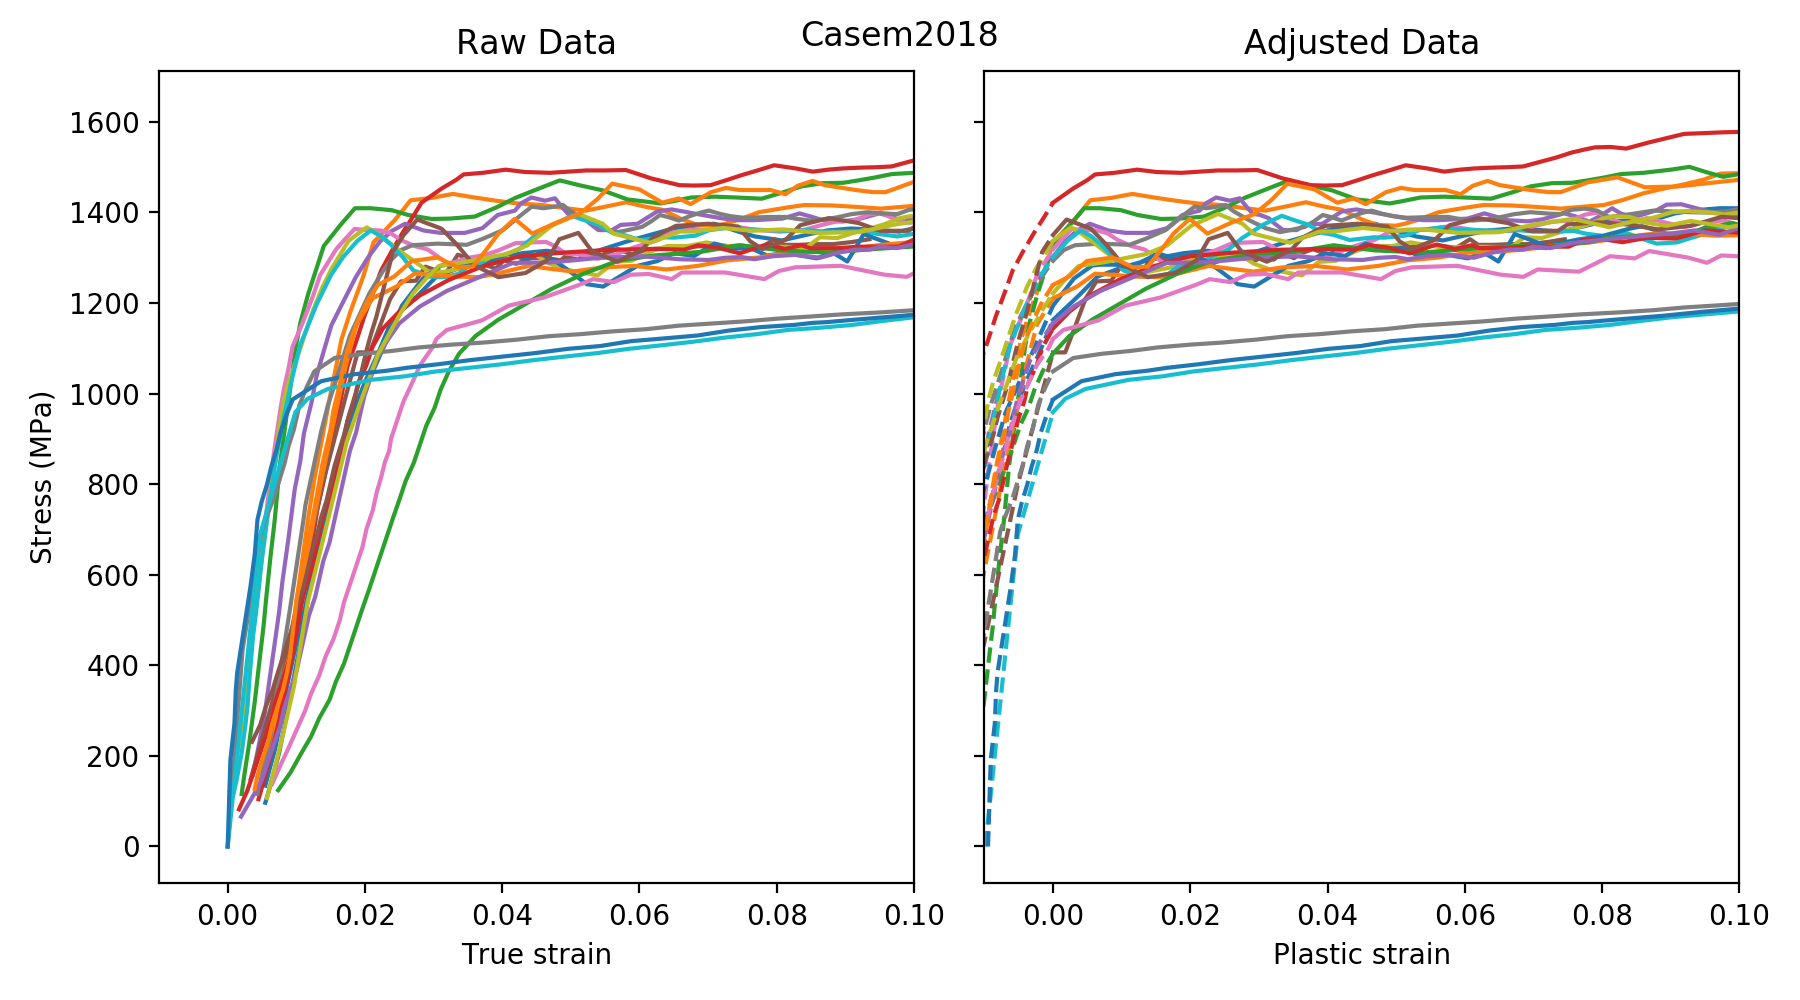

In [78]:
k = "Casem2018"
threshold = 21e3
xax_lim = (-0.01, 0.1)
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(9, 5))
for ii, kk in enumerate(name_dict[k]):
    x = name_dict[k][kk]["True strain"]
    y = name_dict[k][kk][" stress (MPa)"]
    # Compute first order spline
    y_spl = sci.UnivariateSpline(x, y, s=0, k=1)

    # Compute 2nd derivative of spline, near linear sections going to have near zero 2nd derivative
    x_range = nmp.linspace(x.values[0], x.values[-1], 1000)
    grad1 = nmp.gradient(y_spl(x_range), x_range)
    grad2 = nmp.gradient(grad1, x_range)

    # Compute 1st and 2nd derivative of spline, near linear sections going to have near zero 2nd derivative
    x_range = nmp.linspace(x.values[0], x.values[-1], 1000)
    grad1 = nmp.gradient(y_spl(x_range), x_range)
    grad2 = nmp.gradient(grad1, x_range)

    # Find where slope ofd the spline decreases below threshold value to find non-linearity
    for index, value in enumerate(grad1):
        if abs(value) < threshold:
            x_yield_temp = x_range[index]
            x_index = (nmp.abs(x_yield_temp - x)).idxmin()
            x_yield = x.values[x_index]
            break

    # Split original strain vector into old and new
    x_elastic = x.values[: x_index + 1] - x_yield
    y_elastic = y.values[: x_index + 1]

    x_plastic = x.values[x_index:] - x_yield
    y_plastic = y.values[x_index:]

    # Read old .csv file and write new plastic strain/stress data
    true_filename = os.path.join(location, k, kk) + ".csv"
    true_lines = []
    with open(true_filename, "r") as fr:
        for linenum, line in enumerate(fr):
            if linenum < 17:
                true_lines.append(line)

    # Write new .csv file with plastic strain
    plastic_filename = os.path.join(location, k, kk) + ".Plast.csv"
    plastic_lines = ["Plastic strain, stress (MPa)\n"]
    for strain_index, plast_strain in enumerate(x_plastic):
        strain_string = "{eps:.6}, {omega:.6}\n".format(
            eps=plast_strain, omega=y_plastic[strain_index]
        )
        plastic_lines.append(strain_string)

    write_lines = true_lines + plastic_lines
    with open(plastic_filename, "w") as fw:
        for write_line in write_lines:
            fw.write(write_line)

    # Plot original and offset results
    ax1.plot(x, y)

    # Plot shifted elastic...
    ax2.plot(x_elastic, y_elastic, "--")
    # ... and plastic data
    ax2.plot(x_plastic, y_plastic, "-", color=plt.gca().lines[-1].get_color())
fig.suptitle(k, fontsize=12)
ax1.set(
    title="Raw Data",
    xlabel="True strain",
    ylabel="Stress (MPa)",
    xlim=xax_lim,
    #         ylim=(-100,1500),
)
ax2.set(
    title="Adjusted Data",
    xlabel="Plastic strain",
    xlim=xax_lim,
)
plt.tight_layout()